In [2]:
import numpy as np
import torch
import matplotlib.pyplot as plt


In [3]:
np.random.seed(45)
num_samples = 40
    
# Generate data
x1 = np.random.uniform(-1, 1, num_samples)
f_x = 3*x1 + 4
eps = np.random.randn(num_samples)
y = f_x + eps

ones = np.ones(x1.shape)
X = torch.from_numpy(np.column_stack((ones,x1)))
X = X.to(torch.float32)
y = torch.from_numpy(y)
y = y.to(torch.float32)

In [4]:
def true_gradient(X,y,theta):
    theta.requires_grad_(True)
    y_pred = torch.matmul(X,theta)
    loss = torch.mean((y_pred-y)**2)
    loss.backward()
    return theta.grad.detach().clone()

def stochastic_gradient(X,y,theta,num_samples):
    gradients = []
    theta.requires_grad_(True)
    theta.grad.zero_()
    for i in range(num_samples):
        y_pred = torch.matmul(X[i],theta)
        loss = (y_pred-y[i])**2
        loss.backward()
        gradients.append(theta.grad.clone())
        theta.grad.zero_()
    return sum(gradients)/num_samples

In [5]:
for trial in range(5):
    theta = torch.randint(0,10,(2,),dtype = torch.float32)
    True_gradient = true_gradient(X,y,theta)
    Stochastic_gradient = stochastic_gradient(X,y,theta,num_samples) 

    print(f'Trial {trial+1}')
    print(f"Theta Value:       {theta[0]:.4f}, {theta[1]:.4f}")
    print(f"True Gradient:       {True_gradient[0]:.4f}, {True_gradient[1]:.4f}")
    print(f"Stochastic Gradient: {Stochastic_gradient[0]:.4f}, {Stochastic_gradient[1]:.4f}")
    print()


Trial 1
Theta Value:       4.0000, 9.0000
True Gradient:       -0.9715, 3.9823
Stochastic Gradient: -0.9715, 3.9823

Trial 2
Theta Value:       0.0000, 8.0000
True Gradient:       -8.8021, 4.0282
Stochastic Gradient: -8.8021, 4.0282

Trial 3
Theta Value:       3.0000, 0.0000
True Gradient:       -1.4471, -1.5334
Stochastic Gradient: -1.4471, -1.5334

Trial 4
Theta Value:       2.0000, 2.0000
True Gradient:       -3.7858, -0.1007
Stochastic Gradient: -3.7858, -0.1007

Trial 5
Theta Value:       8.0000, 8.0000
True Gradient:       7.1979, 2.6731
Stochastic Gradient: 7.1979, 2.6731



In [12]:
def true_gradient_descent(X,y,theta,learning_rate,epsilon,max_epochs):
    theta_evolution = []
    loss_tgd = []
    epoch_count = max_epochs
    for epoch in range(max_epochs):
        
        y_pred = torch.matmul(X,theta)
        loss = torch.mean((y_pred - y)**2)
        loss_tgd.append(loss.item())
        loss.backward()
        grad_norm = torch.norm(theta.grad)
        if grad_norm < epsilon:
            epoch_count = epoch+1
            break
        theta_evolution.append(theta.clone().detach())

        with torch.no_grad():
            theta -= theta.grad*learning_rate
            theta.grad.zero_()
        
    return theta_evolution,epoch_count,loss_tgd


def stochastic_gradient_descent(X,y,theta,learning_rate,epsilon,max_epochs,num_samples):
    theta_evolution = []
    loss_tgd = []
    epoch_count = max_epochs
    for epoch in range(max_epochs):
        for i in range(num_samples):
            y_pred = torch.matmul(X[i],theta)
            loss = torch.mean((y_pred - y[i])**2)
            loss_tgd.append(loss.item())
            loss.backward()
            grad_norm = torch.norm(theta.grad)
            theta_evolution.append(theta.clone().detach())

            with torch.no_grad():
                theta -= theta.grad*learning_rate
                theta.grad.zero_()

        if grad_norm < epsilon:
            epoch_count = epoch+1
            break
        
    return theta_evolution,epoch_count,loss_tgd

def mini_batch_gradient_descent(X,y,theta,learning_rate,epsilon,max_epochs,num_samples,batch_size):
    theta_evolution = []
    loss_tgd = []
    epoch_count = max_epochs
    batch = int(num_samples/batch_size)
    for epoch in range(max_epochs):
        for i in range(batch):
            y_pred = torch.matmul(X[i*batch_size:(i+1)*batch_size],theta)
            loss = torch.mean((y_pred - y[i*batch_size:(i+1)*batch_size])**2)
            loss_tgd.append(loss.item())
            loss.backward()
            grad_norm = torch.norm(theta.grad)
            theta_evolution.append(theta.clone().detach())

            with torch.no_grad():
                theta -= theta.grad*learning_rate
                theta.grad.zero_()

        if grad_norm < epsilon:
            epoch_count = epoch+1
            break
        
    return theta_evolution,epoch_count,loss_tgd

def gradient_descent_with_momentum(X, y, theta, learning_rate, epsilon, max_epochs, beta):
    theta_evolution_gdm = []
    loss_gdm = []
    epoch_count = max_epochs
    velocity = torch.zeros_like(theta)  
    
    for epoch in range(max_epochs):
        y_pred = torch.matmul(X, theta)
        loss = torch.mean((y_pred - y)**2)
        loss_gdm.append(loss.item())
        loss.backward()
        
        grad_norm = torch.norm(theta.grad)
        
        if grad_norm < epsilon:
            epoch_count = epoch + 1
            break
        
        theta_evolution_gdm.append(theta.clone().detach())
        
        with torch.no_grad():
            velocity = beta * velocity + (1 - beta) * theta.grad
            theta -= learning_rate * velocity  
            theta.grad.zero_()
    
    return theta_evolution_gdm, epoch_count, loss_gdm


In [14]:
max_epochs = 15
learning_rate = 0.5
epsilon = 0.001
batch_size = 5
beta = 0.9
theta = torch.randint(2,10,(2,),dtype = torch.float32,requires_grad = True)
theta_evolution_tgd,eps_count_tgd,loss_tgd = true_gradient_descent(X,y,theta,learning_rate,epsilon,max_epochs)
learning_rate = 0.2
theta_evolution_sgd,eps_count_sgd,loss_sgd = stochastic_gradient_descent(X,y,theta,learning_rate,epsilon,max_epochs,num_samples)
learning_rate = 0.5
theta_evolution_mbgd,eps_count_mbgd,loss_mbgd =mini_batch_gradient_descent(X,y,theta,learning_rate,epsilon,max_epochs,num_samples,batch_size)
theta_evolution_gdm,eps_count_gdm,loss_gdm  =gradient_descent_with_momentum(X, y, theta, learning_rate, epsilon, max_epochs, beta)



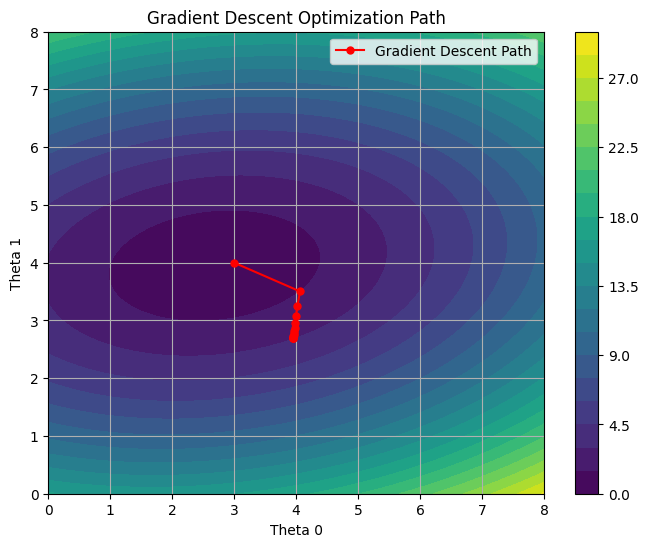

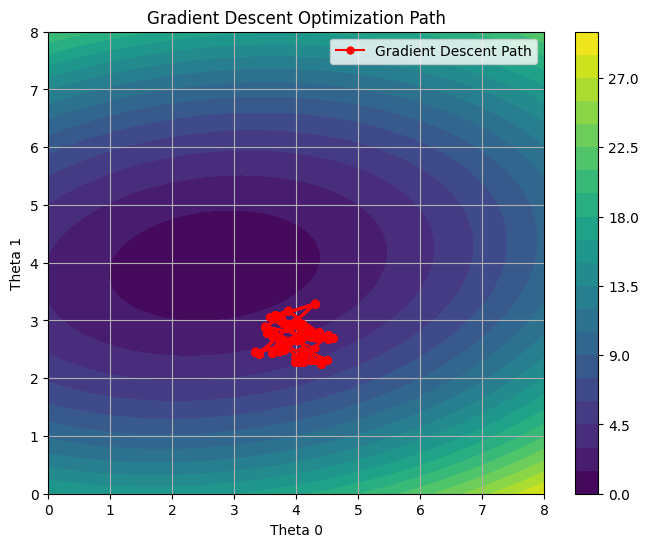

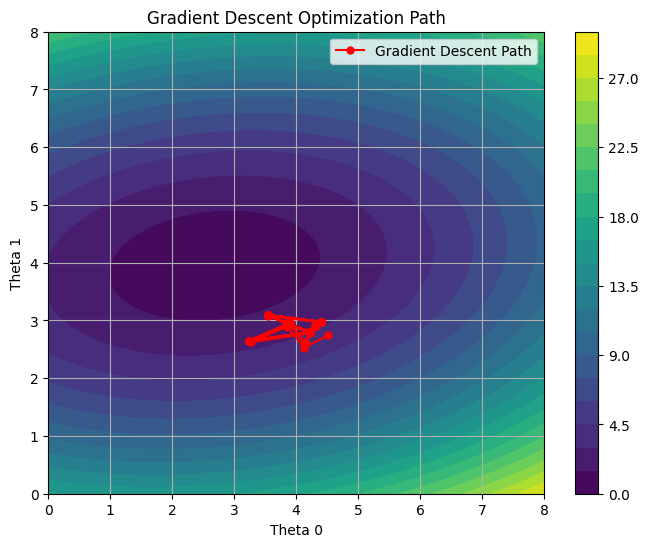

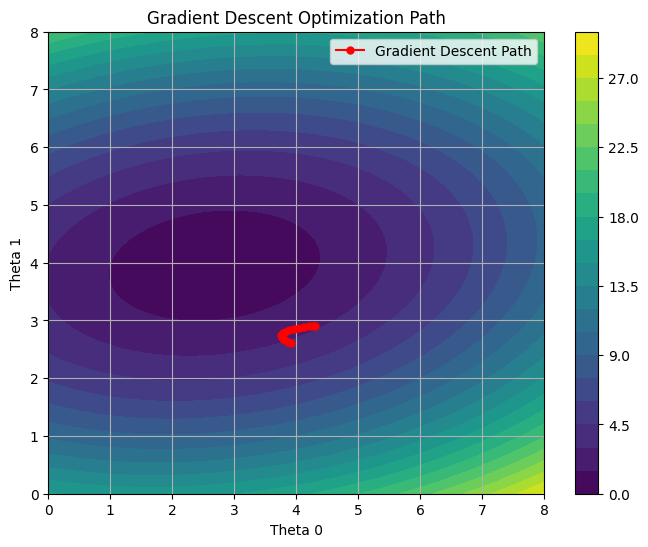

In [16]:
import matplotlib.pyplot as plt
import numpy as np
import torch

def simple_contour_with_gd(X, y, theta_evolution, loss_func):
    # Create a grid of values for theta
    theta0_vals = np.linspace(0, 8, 200)  # Increased resolution of grid
    theta1_vals = np.linspace(0, 8, 200)
    
    # Compute the loss for each combination of theta values
    Z = np.zeros((len(theta0_vals), len(theta1_vals)))
    for i, theta0 in enumerate(theta0_vals):
        for j, theta1 in enumerate(theta1_vals):
            theta_grid = torch.tensor([theta0, theta1], dtype=torch.float32)
            Z[i, j] = loss_func(theta_grid, X, y).item()
    
    # Set up the contour plot
    fig, ax = plt.subplots(figsize=(8, 6))
    T0, T1 = np.meshgrid(theta0_vals, theta1_vals)
    
    # Adjust contour levels based on the range of values in Z for better visualization
    contour = ax.contourf(T0, T1, Z, levels=20, cmap="viridis")
    plt.colorbar(contour)
    
    # Ensure theta_evolution is a NumPy array (from list of tensors)
    theta_evolution_np = np.array([theta.detach().numpy() for theta in theta_evolution])

    # Plot the path of gradient descent
    ax.plot(theta_evolution_np[:, 0], theta_evolution_np[:, 1], 'r-o', label="Gradient Descent Path", markersize=5)
    
    ax.set_xlabel('Theta 0')
    ax.set_ylabel('Theta 1')
    ax.set_title('Gradient Descent Optimization Path')
    plt.legend()
    plt.grid(True)
    plt.show()

# Loss function for gradient descent
def loss_func(theta, X, y):
    y_pred = torch.matmul(X, theta)
    return torch.mean((y_pred - y)**2)

# Call the function with your data
simple_contour_with_gd(X, y, theta_evolution_tgd, loss_func)
simple_contour_with_gd(X, y, theta_evolution_sgd, loss_func)
simple_contour_with_gd(X, y, theta_evolution_mbgd, loss_func)
simple_contour_with_gd(X, y, theta_evolution_gdm, loss_func)


In [ ]:
|